In [3]:
import typing as tp

import numpy as np
from sklearn.neighbors import NearestNeighbors

In [4]:
def uniform_kernel(distances: np.ndarray) -> np.ndarray:
    return np.where(distances < 1, 1, 0)


def gaussian_kernel(distances: np.ndarray) -> np.ndarray:
    return np.exp(-0.5 * distances ** 2)


def epanechnikov_kernel(distances: np.ndarray) -> np.ndarray:
    return np.where(distances < 1, 0.75 * (1 - distances ** 2), 0)


def custom_kernel(distances: np.ndarray) -> np.ndarray:
    return np.ones_like(distances) * 0.5


def cosine_distance(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    dot_product = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    cosine_similarity = dot_product / (norm_x * norm_y)
    return 1 - cosine_similarity


def minkowski_distance(x: np.ndarray, y: np.ndarray, p: int = 2) -> np.ndarray:
    return np.sum(np.abs(x - y) ** p) ** (1 / p)


def custom_distance(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return np.sum(np.abs(x - y) ** 2)


In [5]:
MetricFunction = tp.Callable[[np.ndarray, np.ndarray], np.ndarray]
KernelFunction = tp.Callable[[np.ndarray], np.ndarray]


def create_minkowski_distance(p: int) -> MetricFunction:
    def distance(x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return minkowski_distance(x, y, p)

    return distance

In [6]:
class CustomKnn:
    def __init__(
            self,
            k: int = 3,
            window: str = 'fixed',
            fixed_radius: float = 1.0,
            kernel: str = 'UNIFORM',
            metric: str = 'MINKOWSKI',
            p: int = 2,
            sample_weights: tp.Optional[np.ndarray] = None,
            lowess: bool = False
    ) -> None:
        self.k: int = k
        self.window: str = window
        self.fixed_radius: float = fixed_radius
        self.kernel_f: KernelFunction = self._init_kernel_function(kernel)
        self.p: int = p
        self.metric_f: MetricFunction = self._init_metric_function(metric)
        self.sample_weights: tp.Optional[np.ndarray] = sample_weights
        self.X_train: tp.Optional[np.ndarray] = None
        self.y_train: tp.Optional[np.ndarray] = None
        self.nearest_neighbor: tp.Optional[NearestNeighbors] = None
        self.classes_ = None
        self.lowess: bool = lowess

    @staticmethod
    def _init_kernel_function(kernel: str) -> KernelFunction:
        match kernel:
            case 'UNIFORM':
                return uniform_kernel
            case 'GAUSSIAN':
                return gaussian_kernel
            case 'EPANECHNIKOV':
                return epanechnikov_kernel
            case 'CUSTOM':
                return custom_kernel
            case _:
                raise ValueError(f'Unknown kernel function: {kernel}')

    def _init_metric_function(self, metric: str) -> MetricFunction:
        match metric:
            case 'COSINE':
                return cosine_distance
            case 'MINKOWSKI':
                return create_minkowski_distance(self.p)
            case 'CUSTOM':
                return custom_distance
            case _:
                raise ValueError(f'Unknown metric function: {metric}')

    def _init_data(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        if X_train.shape[0] != y_train.shape[0]:
            raise ValueError('Number of training samples does not match')
        self.X_train: np.ndarray = X_train
        self.y_train: np.ndarray = y_train

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        self._init_data(X_train, y_train)
        self.nearest_neighbor: NearestNeighbors = NearestNeighbors(n_neighbors=self.k, metric=self.metric_f)
        self.nearest_neighbor.fit(X_train)
        self.classes_ = np.unique(y_train)
        if self.lowess:
            self.sample_weights = self._apply_lowess(X_train, y_train)

    def predict(self, X: np.ndarray) -> np.ndarray:
        distances, divisors, indexes = self._calc_by_window_type(X)
        predictions = []
        items_count = X.shape[0]
        for item in range(items_count):
            neighbour_distances, neighbour_indexes = self._normalize_distances(distances, divisors, indexes, item)
            neighbor_labels = self.y_train[neighbour_indexes]
            kernel_weights = self.kernel_f(neighbour_distances)
            if self.sample_weights is not None:
                prior_weights = self.sample_weights[neighbour_indexes]
                combined_weights = kernel_weights * prior_weights
            else:
                combined_weights = kernel_weights

            prediction = self._get_most_relevant_class(combined_weights, neighbor_labels)

            predictions.append(prediction)
        return np.array(predictions)

    def _calc_by_window_type(self, X) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        items_count = X.shape[0]
        if self.window == "FIXED":
            distances, indexes = self.nearest_neighbor.kneighbors(X=X, n_neighbors=self.k)
            filtered_distances = np.full((items_count, self.k), np.inf)
            filtered_indexes = np.full((items_count, self.k), -1, dtype=int)
            for i in range(items_count):
                neighbor_dists = distances[i]
                in_radius_mask = neighbor_dists <= self.fixed_radius
                current_distances = neighbor_dists[in_radius_mask]
                current_indexes = indexes[i][in_radius_mask]
                if len(current_distances) > self.k:
                    sorted_indices = np.argsort(current_distances)
                    current_distances = current_distances[sorted_indices][:self.k]
                    current_indexes = current_indexes[sorted_indices][:self.k]
                filtered_distances[i, :len(current_distances)] = current_distances
                filtered_indexes[i, :len(current_indexes)] = current_indexes

            distances = filtered_distances
            indexes = filtered_indexes
            divisors = np.full(items_count, self.fixed_radius)
        elif self.window == "NON_FIXED":
            distances, indexes = self.nearest_neighbor.kneighbors(X=X, n_neighbors=self.k + 1)
            divisors = distances[:, -1]
            distances = distances[:, :-1]
            indexes = indexes[:, :-1]
        else:
            raise ValueError('Window must be FIXED or NON_FIXED')
        return distances, divisors, indexes

    def _apply_lowess(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        weights = []
        for i in range(len(X)):
            knn = CustomKnn(k=9, fixed_radius=1, kernel='UNIFORM', metric='COSINE', window='NON_FIXED')
            knn.fit(np.delete(X, i, axis=0), np.delete(y, i, axis=0))
            new_y = (knn.predict(np.array([X[i]]))[0])
            if self.kernel_f is not None:
                weight = self.kernel_f(np.array(0 if y[i] == new_y else 1))
            else:
                weight = 0 if y[i] == new_y else 1
            weights.append(weight)
        return np.array(weights)

    def _normalize_distances(
            self,
            distances: np.ndarray,
            divisors: np.ndarray,
            indexes: np.ndarray,
            item: int
    ) -> tuple[np.ndarray, np.ndarray]:
        neighbour_distances = distances[item] / divisors[item]
        neighbour_indexes = indexes[item]
        if len(distances[item]) > self.k:
            neighbour_distances = neighbour_distances[:self.k]
            neighbour_indexes = neighbour_indexes[:self.k]
        return neighbour_distances, neighbour_indexes

    def _get_most_relevant_class(self, combined_weights: np.ndarray, neighbor_labels: np.ndarray) -> int:
        classes_votes = np.zeros(len(self.classes_), dtype=float)
        num_neighbors = min(self.k, len(neighbor_labels))
        for i in range(num_neighbors):
            _class: int = int(neighbor_labels[i])
            classes_votes[_class] += combined_weights[i]
        prediction: int = int(np.argmax(classes_votes))
        return prediction


In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
def _get_split_data() -> tp.Any:
    data = load_iris()
    X, y = data.data, data.target
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
    return X_test, X_train, y_test, y_train

In [9]:
def pretty_print_best_params(best_params: dict, best_score: float) -> None:
    print(f"Best Score: {best_score:.4f}")
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")


def print_accuracy(y_pred, y_test) -> None:
    test_accuracy = custom_accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy}")


def custom_accuracy_score(y_true: np.ndarray, y_pred: np.ndarray, alpha: int = 1) -> float:
    correct_predictions = np.sum(y_true == y_pred) * alpha
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [10]:
def test_model() -> None:
    X_test, X_train, y_test, y_train = _get_split_data()
    knn = CustomKnn(k=119, window='FIXED', fixed_radius=0.33, metric='MINKOWSKI', p=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print_accuracy(y_pred, y_test)


test_model()

Test Accuracy: 0.9


In [11]:
import optuna

In [12]:
def func(trial, X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray) -> float:
    k = trial.suggest_int('k', 3, 20)
    p = trial.suggest_int('p', 1, 4)
    window = trial.suggest_categorical('window', ['FIXED', 'NON_FIXED'])
    fixed_radius = trial.suggest_float('fixed_radius', 0.5, 5.0)
    kernel = trial.suggest_categorical('kernel', ['UNIFORM', 'GAUSSIAN', 'EPANECHNIKOV'])
    metric = trial.suggest_categorical('metric', ['COSINE', 'MINKOWSKI'])
    knn = CustomKnn(
        k=k,
        window=window,
        fixed_radius=fixed_radius,
        kernel=kernel,
        metric=metric,
        p=p
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    accuracy = custom_accuracy_score(y_val, y_pred)
    return accuracy

In [13]:
def get_best_hyperparameters(
        X_train: np.ndarray, X_val: np.ndarray, y_train: np.ndarray, y_val: np.ndarray
) -> tuple[dict, float]:
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: func(trial, X_train, X_val, y_train, y_val),
        n_trials=1000,
        show_progress_bar=True
    )
    best_params = study.best_params
    best_value = study.best_value
    return best_params, best_value

In [14]:
def get_split_data():
    data = load_iris()
    X, y = data.data, data.target
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    return X_test, X_train, X_val, y_test, y_train, y_val

In [46]:
X_test, X_train, X_val, y_test, y_train, y_val = get_split_data()
best_params, best_score = get_best_hyperparameters(X_train, X_val, y_train, y_val)
print("~" * 40)
pretty_print_best_params(best_params, best_score)

[I 2024-09-11 21:01:34,750] A new study created in memory with name: no-name-3cdd1e60-0893-4bdb-b479-bbc2a12c28aa


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-09-11 21:01:34,769] Trial 0 finished with value: 0.875 and parameters: {'k': 18, 'p': 3, 'window': 'FIXED', 'fixed_radius': 0.9101849918960438, 'kernel': 'GAUSSIAN', 'metric': 'COSINE'}. Best is trial 0 with value: 0.875.
[I 2024-09-11 21:01:34,779] Trial 1 finished with value: 0.8333333333333334 and parameters: {'k': 4, 'p': 3, 'window': 'FIXED', 'fixed_radius': 1.4302282252752274, 'kernel': 'UNIFORM', 'metric': 'COSINE'}. Best is trial 0 with value: 0.875.
[I 2024-09-11 21:01:34,789] Trial 2 finished with value: 0.8333333333333334 and parameters: {'k': 5, 'p': 4, 'window': 'NON_FIXED', 'fixed_radius': 3.740829315051454, 'kernel': 'GAUSSIAN', 'metric': 'COSINE'}. Best is trial 0 with value: 0.875.
[I 2024-09-11 21:01:34,800] Trial 3 finished with value: 0.7916666666666666 and parameters: {'k': 10, 'p': 3, 'window': 'NON_FIXED', 'fixed_radius': 2.508892129285691, 'kernel': 'EPANECHNIKOV', 'metric': 'COSINE'}. Best is trial 0 with value: 0.875.
[I 2024-09-11 21:01:34,811] Trial 

In [47]:
import matplotlib.pyplot as plt

In [48]:
def plot_accuracy_vs_k(X_test, X_train, y_test, y_train, kernel, window, fixed_radius, metric):
    ks = range(1, 30)
    train_accuracies = []
    test_accuracies = []

    for k in ks:
        knn = CustomKnn(k=k, kernel=kernel, metric=metric, fixed_radius=fixed_radius, window=window)
        knn.fit(X_train, y_train)

        y_train_pred = knn.predict(X_train)
        train_accuracies.append(custom_accuracy_score(y_train, y_train_pred))

        y_test_pred = knn.predict(X_test)
        test_accuracies.append(custom_accuracy_score(y_test, y_test_pred))

    plt.plot(ks, train_accuracies, label='Train Accuracy')
    plt.plot(ks, test_accuracies, label='Test Accuracy')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Neighbors')
    plt.legend()
    plt.show()

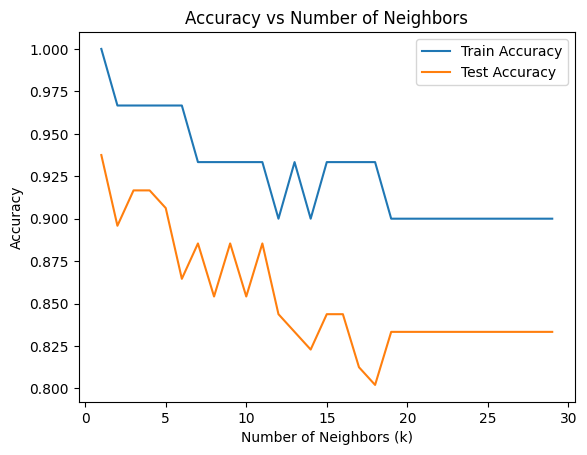

In [49]:
plot_accuracy_vs_k(X_train, X_test, y_train, y_test,
                   kernel=best_params['kernel'],
                   window=best_params['window'],
                   fixed_radius=best_params['fixed_radius'],
                   metric=best_params['metric'])

In [22]:
X_test, X_train, y_test, y_train = _get_split_data()
knn = CustomKnn(k=119, window='FIXED', fixed_radius=0.33, metric='MINKOWSKI', p=5, lowess=True)
knn.fit(X_train, y_train)
knn.sample_weights

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1])

In [23]:
y_pred = knn.predict(X_test)
print_accuracy(y_pred, y_test)

Test Accuracy: 0.8666666666666667
